# FF-VUS

## Setup

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import importlib

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

project_root_path = os.path.join('..', '..')

In [3]:
# Consistent color palette
color_palette = {
    'FF-VUS (L: 128)': '#c8b400',          # Good
    'FF-VUS-GPU (L: 128)': '#40da70',     # Very Good
    'AUC': '#f1a73f',                # Secondary competitor
    'VUS (L: 128)': '#b02a41',            # Main competitor
    'AFFILIATION': '#A5D1C2',        # Useless competitors
    'Range-AUC (L: 128)': '#547C6E',       # Useless competitors
    'RF': '#123327',                    # Useless competitors
}

# Map shorthand names to formal names
formal_names = {
    'FF-VUS': 'FF-VUS (L: 128)',
    'FF-VUS-GPU': 'FF-VUS-GPU (L: 128)',
    'AUC': 'AUC',
    'VUS': 'VUS (L: 128)',
    'RF': 'RF',
    'AFFILIATION': 'AFFILIATION',
    'RANGE-AUC': 'Range-AUC (L: 128)',
}

# Default seaborn style
sns.set_style("whitegrid")

In [7]:
def finalize_plot(save_dir, filename):
    plt.tight_layout()
    if filename is not None:
        save_path = os.path.join(save_dir, filename)
        plt.savefig(f"{save_path}.svg", bbox_inches='tight')
        plt.savefig(f"{save_path}.pdf", bbox_inches='tight')
    plt.show()

## Experiment 1: All metrics with default parameters on the TSB-UAD benchmark

In [4]:
experiment_path = os.path.join(project_root_path, 'experiments', 'allmetrics_defparams_tsb')
results_path = os.path.join(experiment_path, 'results')
save_fig_path = os.path.join(experiment_path, 'figures')
os.makedirs(save_fig_path, exist_ok=True)

result_files = [file for file in os.listdir(results_path) if file.endswith('.csv')]

df = pd.DataFrame()
for file in tqdm(result_files, desc="Reading experiments files"):
    file_path = os.path.join(results_path, file)
    curr_df = pd.read_csv(file_path, index_col=0).reset_index()

    anom_time_col = [x for x in curr_df.columns if 'oordinates' in x.lower()]
    if len(anom_time_col) > 0:
        curr_df = curr_df.rename({anom_time_col[0]: 'Anomaly coordinates time'}, axis=1)
    
    df = pd.concat([df, curr_df], ignore_index=True)
    
df['Metric'] = df['Metric'].map(formal_names)
df.sample(3)

Reading experiments files: 100%|██████████| 7/7 [00:00<00:00, 53.40it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Slope size,Metric,Metric value,Metric time,Existence,Step,...,Anomaly coordinates time,Safe mask time,Thresholds time,Score mask time,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time
3911,IOPS/KPI-0efb375b-b902-3661-ab23-9a0bb799f4e3....,8783,6,11.833333,NaN,AFFILIATION,0.647136,0.004565,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4954,YAHOO/YahooA4Benchmark-TS53_data.out,1679,2,1.000000,NaN,AFFILIATION,0.965982,0.000764,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6908,YAHOO/Yahoo_A1real_2_data.out,1438,2,8.000000,NaN,AUC,0.009799,0.000595,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
metric_to_compare = 'VUS (L: 128)'

df_vus = df[df['Metric'] == metric_to_compare].set_index('Time series')
for metric in df['Metric'].unique():
    curr_df = df[df['Metric'] == metric].set_index('Time series')

    common_index = df_vus.index.intersection(curr_df.index)
    curr_speed_up = df_vus.loc[common_index, 'Metric time'] / curr_df.loc[common_index, 'Metric time']
    print(f"{metric}: {curr_speed_up.mean():.2f}x speed up")

Range-AUC (L: 128): 58.31x speed up
VUS (L: 128): 1.00x speed up
AFFILIATION: 128.03x speed up
AUC: 480.69x speed up
RF: 17.24x speed up
FF-VUS (L: 128): 110.71x speed up
FF-VUS-GPU (L: 128): 467.44x speed up


### Runtime Box plots

In [61]:
metric_to_compare = 'VUS (L: 128)'
speed_up_dict = {}

df_vus = df[df['Metric'] == metric_to_compare].set_index('Time series')
for metric in df['Metric'].unique():
    curr_df = df[df['Metric'] == metric].set_index('Time series')

    common_index = df_vus.index.intersection(curr_df.index)
    curr_speed_up = df_vus.loc[common_index, 'Metric time'] / curr_df.loc[common_index, 'Metric time']
    speed_up_dict[metric] = curr_speed_up.mean()
    print(f"{metric}: {speed_up_dict[metric]:.2f}x speed up")

Range-AUC (L: 128): 58.31x speed up
VUS (L: 128): 1.00x speed up
AFFILIATION: 128.03x speed up
AUC: 480.69x speed up
RF: 17.24x speed up
FF-VUS (L: 128): 110.71x speed up
FF-VUS-GPU (L: 128): 467.44x speed up


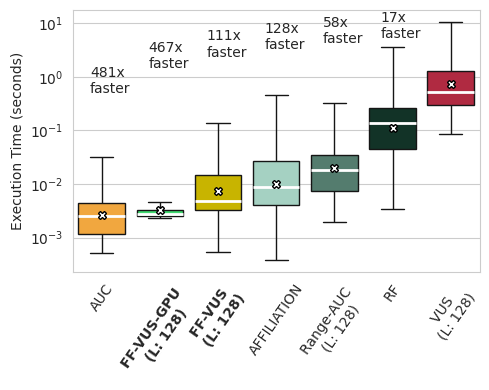

In [179]:
# What is the execution time difference
median_times = df.groupby('Metric')['Metric time'].median()
order = median_times.sort_values().index.to_list()

plt.figure(figsize=(5, 4))

medianprops = dict(linestyle='-', linewidth=2, color='white')
meanprops = dict(
    marker='X',
    markerfacecolor='white',
    markeredgecolor='black',
    markersize=6
)

axis = sns.boxplot(
    y='Metric time',
    x='Metric',
    hue='Metric',
    data=df,
    showfliers=False,
    log_scale=True,
    showmeans=True,
    meanprops=meanprops,
    medianprops=medianprops,
    palette=color_palette,
    order=order,
    saturation=1,
)
axis.set_ylabel('Execution Time (seconds)')
axis.set_xlabel('')
axis.tick_params(axis='x', rotation=55)
axis.grid(visible=False, axis='x')

for i, metric in enumerate(order):
    if i == len(order) - 1:
        break
    axis.annotate(f'{speed_up_dict[metric]:.0f}x\nfaster', xy=(i - .2, 0.5 + i*0.95))

# Highlight the 2nd and 3rd xtick_label in bold
xticklabels = axis.get_xticklabels()
for idx in range(len(axis.get_xticklabels())):
    if 'FF-' in xticklabels[idx].get_text():
        xticklabels[idx].set_fontweight('bold')
    if '(L:' in xticklabels[idx].get_text(): 
        new_text = xticklabels[idx].get_text().replace('(', '\n(')
        xticklabels[idx].set_text(new_text)
axis.set_xticks(axis.get_xticks())
axis.set_xticklabels([label.get_text() for label in xticklabels])

# # Remove borders around the boxes but keep whiskers and caps
# for j, patch in enumerate(axis.patches):
#     facecolor = patch.get_facecolor()
#     if all([x == 1 for x in facecolor]):
#         patch.set_facecolor((1, 1, 1, 0.0))  # alpha = 0.0
#         patch.set_edgecolor((0, 0, 0, 1.0))  # fully opaque border
#         patch.set_linewidth(1.5)

#         axis.lines[j * 6 + 4].set_color('black')    # 6 lines per box and usually the median is the 4th
#         axis.lines[j * 6 + 4].set_linewidth(1.5)
#     else:
#         patch.set_edgecolor(facecolor)
#         patch.set_linewidth(0.5)

finalize_plot(save_fig_path, 'exec_time_comparison_tsb')

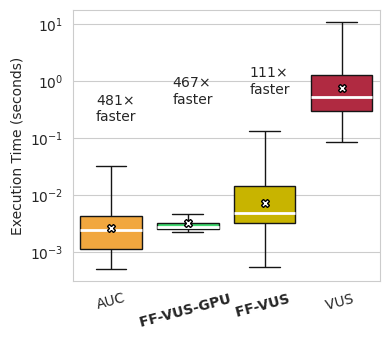

In [159]:
# What is the execution time difference
curr_df  = df[df['Metric'].isin(['AUC', 'FF-VUS-GPU (L: 128)', 'FF-VUS (L: 128)', 'VUS (L: 128)'])]
median_times = curr_df.groupby('Metric')['Metric time'].median()
order = median_times.sort_values().index.to_list()

plt.figure(figsize=(4, 3.5))

axis = sns.boxplot(
    y='Metric time',
    x='Metric',
    hue='Metric',
    data=curr_df,
    showfliers=False,
    log_scale=True,
    showmeans=True,
    meanprops=meanprops,
    medianprops=medianprops,
    palette=color_palette,
    order=order,
    saturation=1,
)
axis.set_ylabel('Execution Time (seconds)')
axis.set_xlabel('')
axis.tick_params(axis='x', rotation=15)
axis.grid(visible=False, axis='x')

for i, metric in enumerate(order):
    if i == len(order) - 1:
        break
    axis.annotate(f'{speed_up_dict[metric]:.0f}$\\times$\nfaster', xy=(i - .2, 0.2 + i*0.2))

# Highlight the 2nd and 3rd xtick_label in bold
xticklabels = axis.get_xticklabels()
for idx in range(len(axis.get_xticklabels())):
    if 'FF-' in xticklabels[idx].get_text():
        xticklabels[idx].set_fontweight('bold')
    if '(L:' in xticklabels[idx].get_text(): 
        new_text = xticklabels[idx].get_text().replace('(L: 128)', '')
        xticklabels[idx].set_text(new_text)
axis.set_xticks(axis.get_xticks())
axis.set_xticklabels([label.get_text() for label in xticklabels])

finalize_plot(save_fig_path, 'exec_time_comparison_tsb_small')

### Error boxplot

In [ ]:
current_metrics = ['FF-VUS (L: 128)', 'FF-VUS-GPU (L: 128)']
vus_df = df[df['Metric'] == 'VUS (L: 128)'].set_index('Time series')

values_df = df[df['Metric'].isin(current_metrics)][['Time series', 'Metric', 'Metric value']]
values_df = values_df.pivot(columns='Metric', index='Time series', values='Metric value')
dif_df = values_df.apply(lambda row: row - vus_df.loc[row.name]['Metric value'], axis=1).abs()
dif_df.head(3)

np.float64(9.992007221626409e-16)

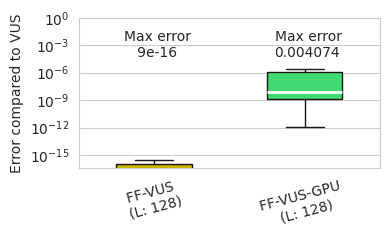

In [178]:
plt.figure(figsize=(4, 2.5))

axis = sns.boxplot(
    dif_df, 
    showfliers=False, 
    fill=True, 
    flierprops={"marker": "o"},
    medianprops=medianprops,
    width=.5, 
    palette=color_palette, 
    saturation=1,
)
axis.set_ylabel('Error compared to VUS')
axis.set_xlabel('')
axis.tick_params(axis='x', rotation=15)
axis.grid(visible=False, axis='x')
axis.set_yscale('log')
axis.set_yticks([10**-x for x in range(0, 16)][::3])

axis.annotate(f'Max error\n   9e-16', (0 - 0.2, 0.00005))
axis.annotate(f'Max error\n{dif_df['FF-VUS-GPU (L: 128)'].max():2f}', (1 - 0.2, 0.00005))

# Highlight the 2nd and 3rd xtick_label in bold
xticklabels = axis.get_xticklabels()
for idx in range(len(axis.get_xticklabels())):
    if '(L:' in xticklabels[idx].get_text(): 
        new_text = xticklabels[idx].get_text().replace('(', '\n(')
        xticklabels[idx].set_text(new_text)
axis.set_xticks(axis.get_xticks())
axis.set_xticklabels([label.get_text() for label in xticklabels])

finalize_plot(save_fig_path, 'ffvus_error_analysis_tsb')